In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
matplotlib.style.use('styles.mplstyle')

from sklearn.decomposition import PCA

In [3]:
d = 10
n = 5

In [4]:
R = np.random.binomial(10, .5, size=(n,d)) - 5

In [297]:
# R = np.random.normal(size=(n,d))

Let $S$ be the matrix with $1$ on the diagonal and $-1$ on the subdiagonal. This is just a trick to ensure that 
\begin{align}
    (SX)_{i,j} = -x_{i-1, j} + x_{i, j} = R_{i,j},
\end{align}
since by definition $x_{i,j} = x_{i-1, j} + r_{i,j}$. The matrix $S$ is invertible, and it's inverse is $S^{-1}$ is a matrix filled with ones below the diagonal.

In [8]:
def get_S(n):
    S = np.identity(n)
    S[1:, : -1] -= np.identity(n-1)
    return S

In [9]:
S = get_S(n)
S_inv = np.tril(np.ones((n,n)))
(np.linalg.inv(S) == S_inv).all()

True

In [320]:
# S[0,-1] = -1
# S[-1,0] = -1

In [12]:
S.T.dot(S)

array([[ 2., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.],
       [ 0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1.,  1.]])

In [14]:
# np.linalg.inv(S.T.dot(S))

Multiplying $SX = R$ by $S^{-1}$ on both sides gives $X = S^{-1}R$.
This is in fact the matrix you get by taking the cumulative sum across all columns of $R$.
To see that, let $s_{i,:}$ be the $i$'th row of $S^{-1}$ and $r_{:, j}$ the $j$-th row of $R$, so that $X_{i,j} = s_{i,:}^T r_{:,j}$. Because $s_{i,:}$ is a row vector filled with 1's up to and including position $i$, and zeros afterwards, we see $X_{i,j} = r_{1, j} + r_{2, j} + \dots + r_{i, j}$. 
That is the cumulative sum of the $j$-th column up to row $i$.
We also get the recurrence relation $X_{i, j} = X_{i-1, j} + r_{i,j}$.

As an example, consider this matrix

In [15]:
R_demo = np.arange(n*d).reshape(d,n).T
R_demo

array([[ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45],
       [ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46],
       [ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47],
       [ 3,  8, 13, 18, 23, 28, 33, 38, 43, 48],
       [ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49]])

When multiplied with $S^{-1}$ we immediately see that it is the column-wise cumulative sum:

In [16]:
assert (S_inv.dot(R_demo) == np.cumsum(R_demo, axis=0)).all()
S_inv.dot(R_demo)

array([[  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.],
       [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91.],
       [  3.,  18.,  33.,  48.,  63.,  78.,  93., 108., 123., 138.],
       [  6.,  26.,  46.,  66.,  86., 106., 126., 146., 166., 186.],
       [ 10.,  35.,  60.,  85., 110., 135., 160., 185., 210., 235.]])

In [17]:
def get_X(R):
    return np.cumsum(R, axis=0)

Next, let $\hat X$ be the matrix obtained by substracting the "mean of every dimension across all steps". 
I presume that is the mean of every *row* (one dimension, all steps) of $X$. 
Analytically, it is convenient to express this using the so-called *centering* matrix.
It is called that way because multiplying it with a vector amounts to substracting the mean of the vector from it.

In [18]:
def centering_matrix(n):
    return np.identity(n) - 1 / n * np.ones(n) 

In [19]:
C4 = centering_matrix(4)
C4, C4.dot(np.arange(1, 5))

(array([[ 0.75, -0.25, -0.25, -0.25],
        [-0.25,  0.75, -0.25, -0.25],
        [-0.25, -0.25,  0.75, -0.25],
        [-0.25, -0.25, -0.25,  0.75]]),
 array([-1.5, -0.5,  0.5,  1.5]))

In numpy we can also subtract the mean directly

In [70]:
Z = np.array([[10, 20, 5], [3, 4, 5]])
C.dot(Z)

array([[ 3.5,  8. ,  0. ],
       [-3.5, -8. ,  0. ]])

In [66]:
Z - Z.mean(axis=1)[:, np.newaxis]

array([[-5. ,  5. ],
       [-0.5,  0.5]])

In [67]:
Z - Z.mean(axis=0)[np.newaxis, :]

array([[ 3.5,  8. ],
       [-3.5, -8. ]])

In [113]:
n = 5
C = centering_matrix(n)
S = get_S(n)
S_inv = np.tril(np.ones((n,n)))
Q = C.dot(S_inv).dot(S_inv.T).dot(C).round(4)

In [118]:
S.T.dot(S)

array([[ 2., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.],
       [ 0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1.,  1.]])

In [120]:
# np.linalg.pinv(Q).round(2)

In [121]:
np.trace(np.linalg.inv(S.T.dot(S)))

15.0

In [114]:
S_inv.dot(S_inv.T)

array([[1., 1., 1., 1., 1.],
       [1., 2., 2., 2., 2.],
       [1., 2., 3., 3., 3.],
       [1., 2., 3., 4., 4.],
       [1., 2., 3., 4., 5.]])

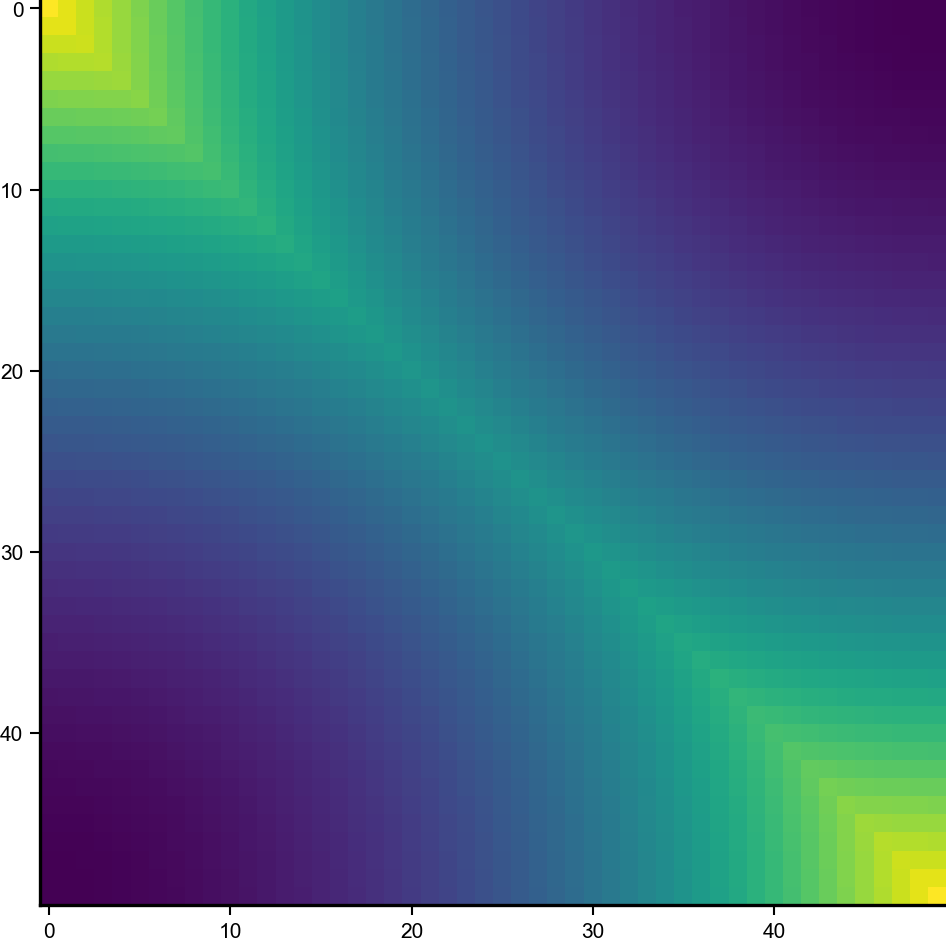

In [109]:
plt.imshow(Q)

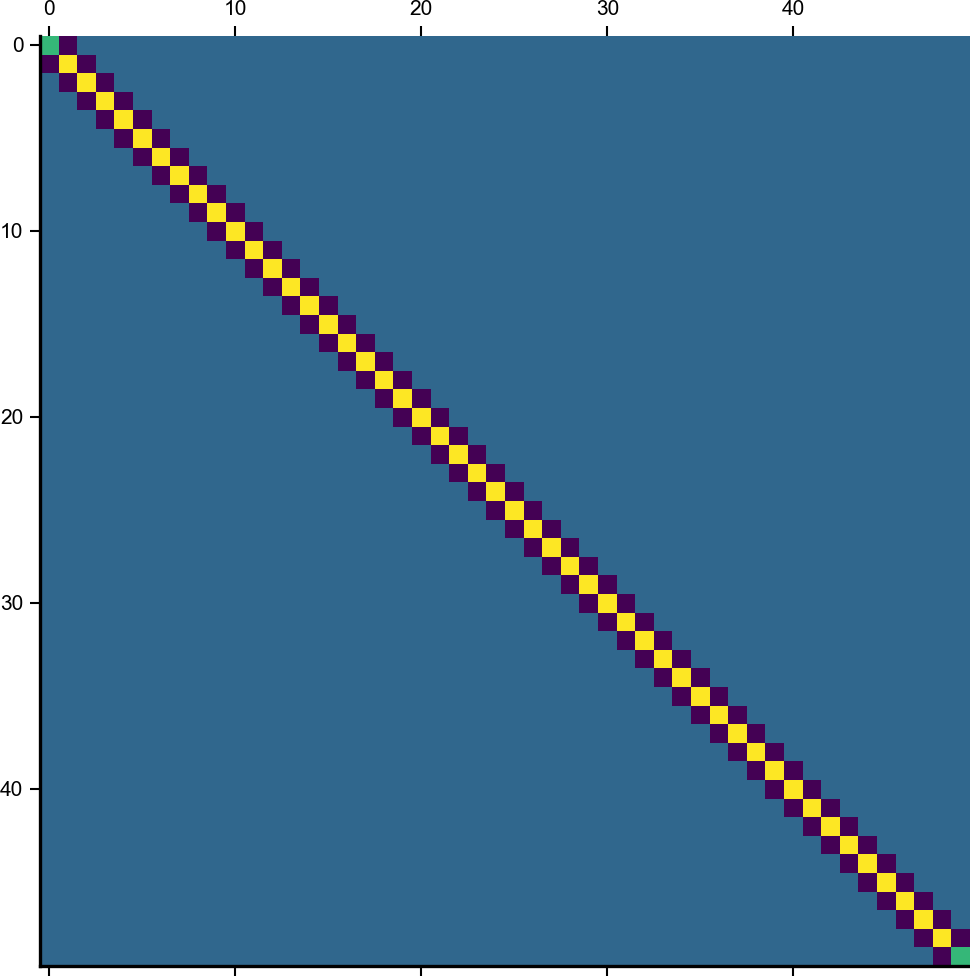

In [111]:
plt.matshow(np.linalg.pinv(Q).round(2))

In [40]:
L, U = np.linalg.eig(Q)

In [52]:
C

array([[ 0.8, -0.2, -0.2, -0.2, -0.2],
       [-0.2,  0.8, -0.2, -0.2, -0.2],
       [-0.2, -0.2,  0.8, -0.2, -0.2],
       [-0.2, -0.2, -0.2,  0.8, -0.2],
       [-0.2, -0.2, -0.2, -0.2,  0.8]])

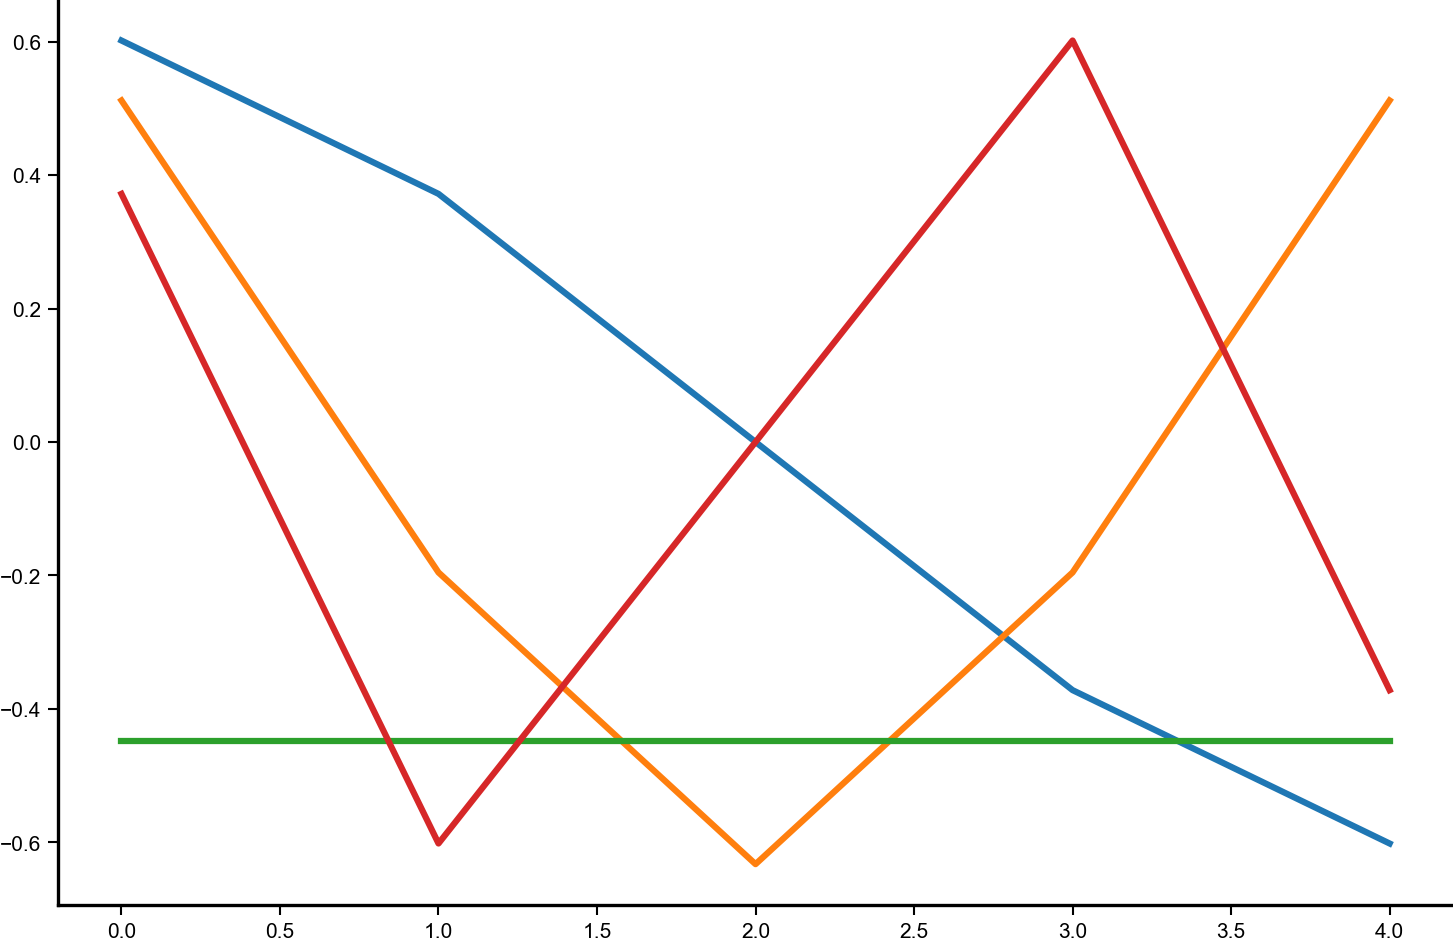

In [51]:
plt.plot(U[:,0])
plt.plot(U[:,1])
plt.plot(U[:,2])
plt.plot(U[:,3])

In [37]:
S.T.dot(S)

array([[ 2., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.],
       [ 0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1.,  1.]])

In [21]:
# np.allclose(
#     centering_matrix(n).dot(get_X(R_demo)),
#     X_demo - X_demo.mean(axis=0)[np.newaxis, :]
# )

In [22]:
def get_X_hat(X):
    return X - X.mean(axis=0)[np.newaxis, :]

In [23]:
get_X_hat(get_X(R))

array([[-1. ,  0. ,  0.6,  2.6,  0. , -2. , -1.6, -2.8, -0.4,  0. ],
       [ 0. ,  1. ,  0.6,  1.6,  0. ,  0. ,  0.4,  1.2,  1.6, -1. ],
       [ 1. ,  0. ,  0.6, -2.4,  1. , -1. ,  1.4,  1.2,  0.6,  1. ],
       [ 0. ,  0. , -1.4, -1.4,  1. ,  2. ,  0.4,  0.2, -0.4,  1. ],
       [ 0. , -1. , -0.4, -0.4, -2. ,  1. , -0.6,  0.2, -1.4, -1. ]])

In [24]:
np.random.seed(0)
R = np.random.binomial(10, .5, size=(50, 3000)) - 5
X = get_X(R)
X_hat = get_X_hat(X)
X_hat.T.dot(X_hat)

array([[  744.98, -1138.24,   660.2 , ...,   482.82,   738.28,  -203.68],
       [-1138.24,  3471.12, -1529.6 , ..., -1238.16, -2033.64,   502.84],
       [  660.2 , -1529.6 ,  1018.  , ...,   714.8 ,  1165.2 ,   -49.2 ],
       ...,
       [  482.82, -1238.16,   714.8 , ...,   689.38,   931.52,    37.88],
       [  738.28, -2033.64,  1165.2 , ...,   931.52,  1642.08,    14.52],
       [ -203.68,   502.84,   -49.2 , ...,    37.88,    14.52,   506.88]])

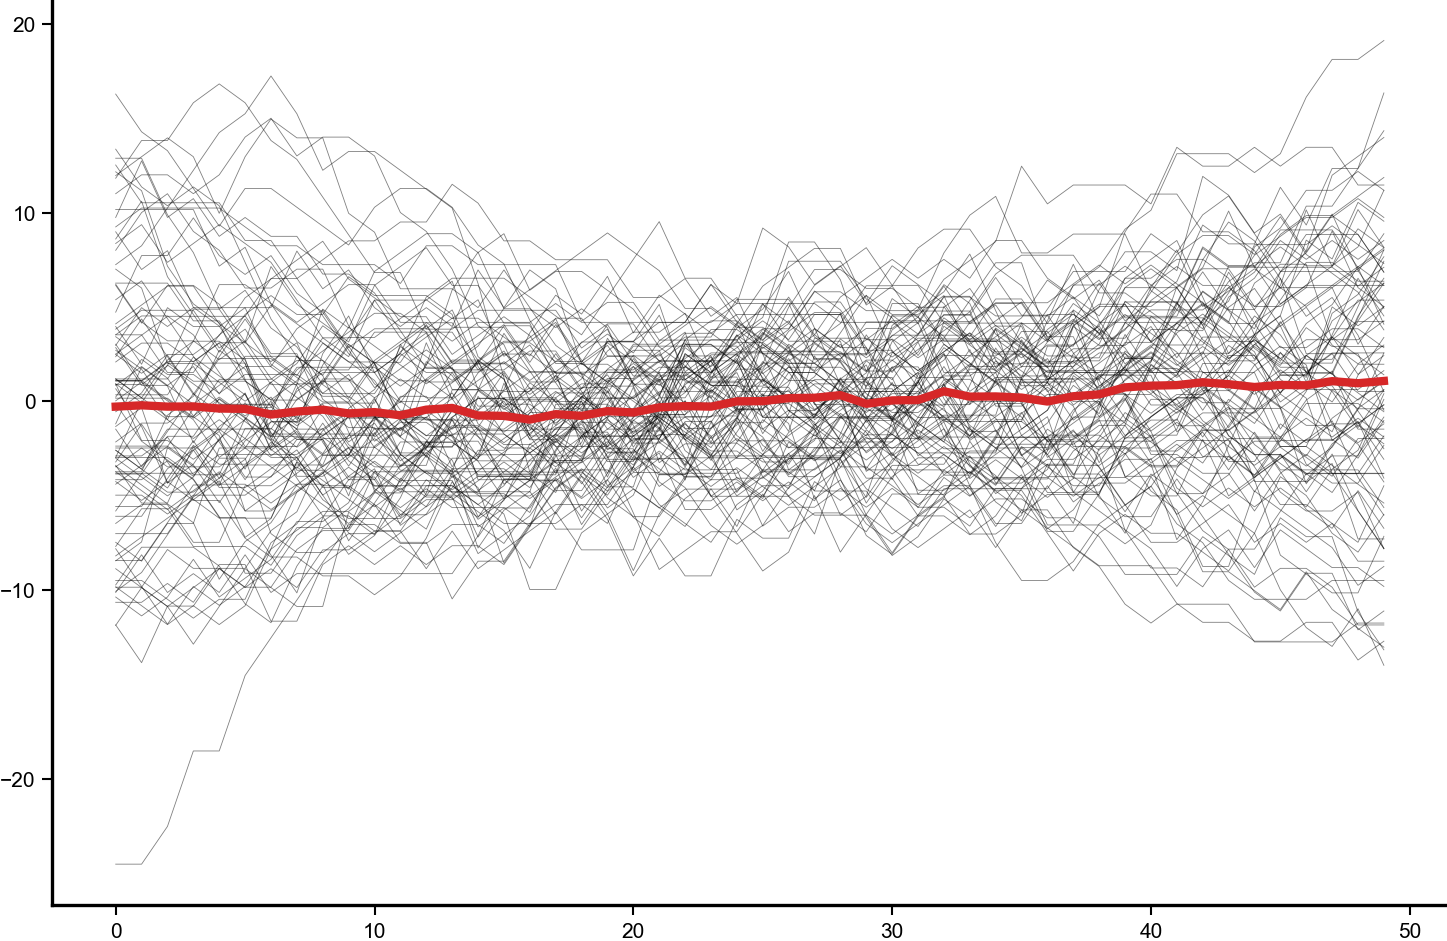

In [25]:
plt.plot(X_hat[:, :100], 'k', lw=.2, alpha=.5);
plt.plot(X_hat[:, :100].mean(axis=1), 'C3', lw=2);

In [16]:
w, v = np.linalg.eig(X_hat.T.dot(X_hat))

In [17]:
X_proj = X.dot(v)

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: 

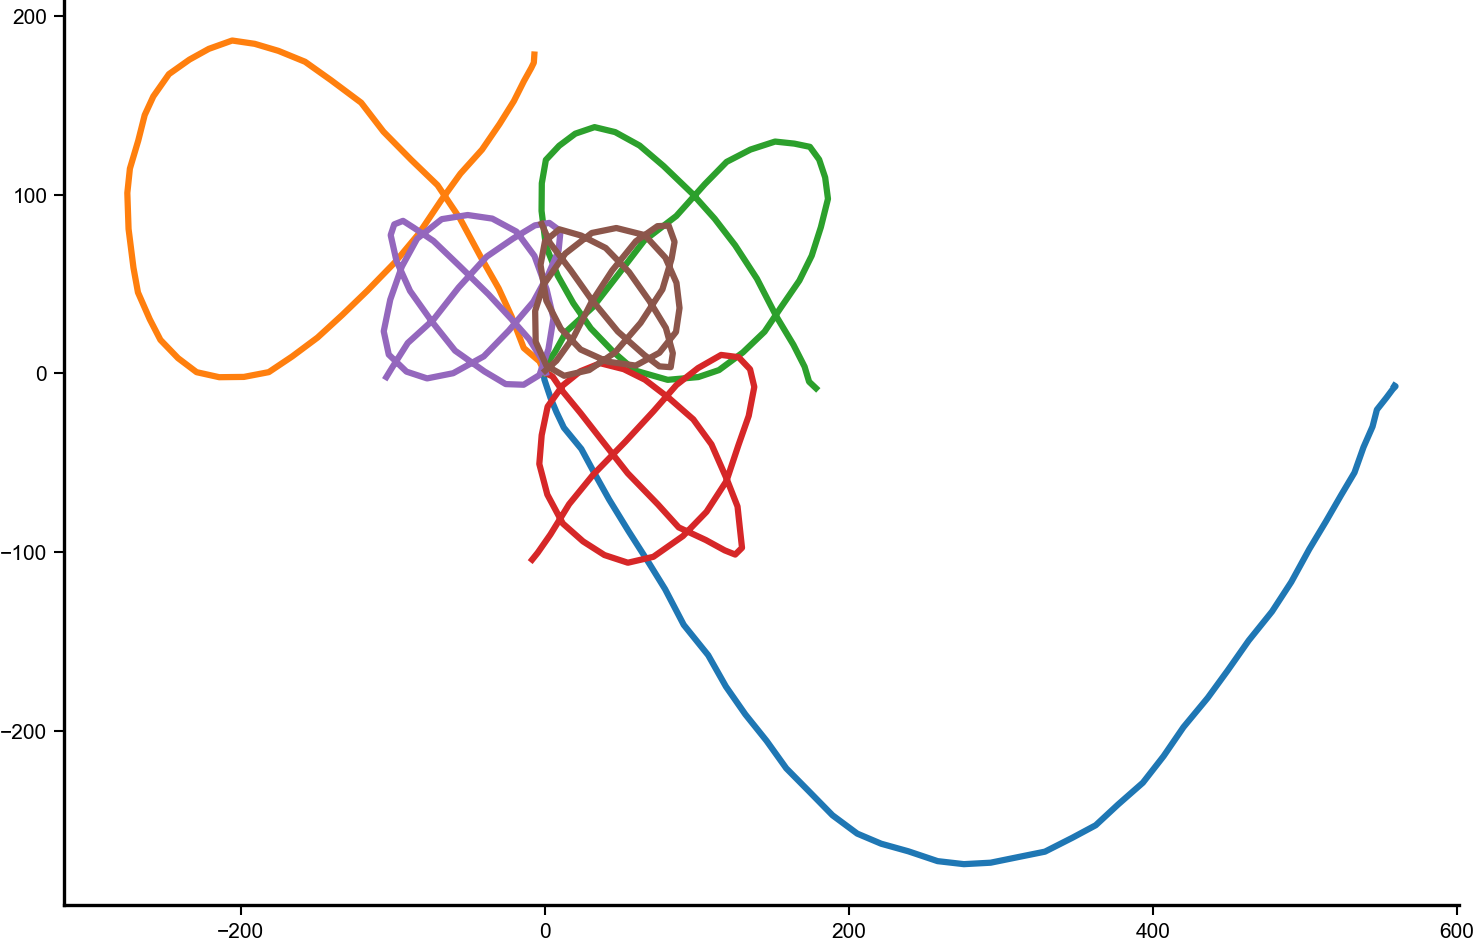

In [18]:
plt.plot(X_proj[:, 0], X_proj[:, 1])
plt.plot(X_proj[:, 1], X_proj[:, 2])
plt.plot(X_proj[:, 2], X_proj[:, 3])
plt.plot(X_proj[:, 3], X_proj[:, 4])
plt.plot(X_proj[:, 4], X_proj[:, 5])
plt.plot(X_proj[:, 5], X_proj[:, 6])

In [64]:
w_T, v_T = np.linalg.eig(X_hat.dot(X_hat.T))

In [68]:
v_T.shape

(50, 50)

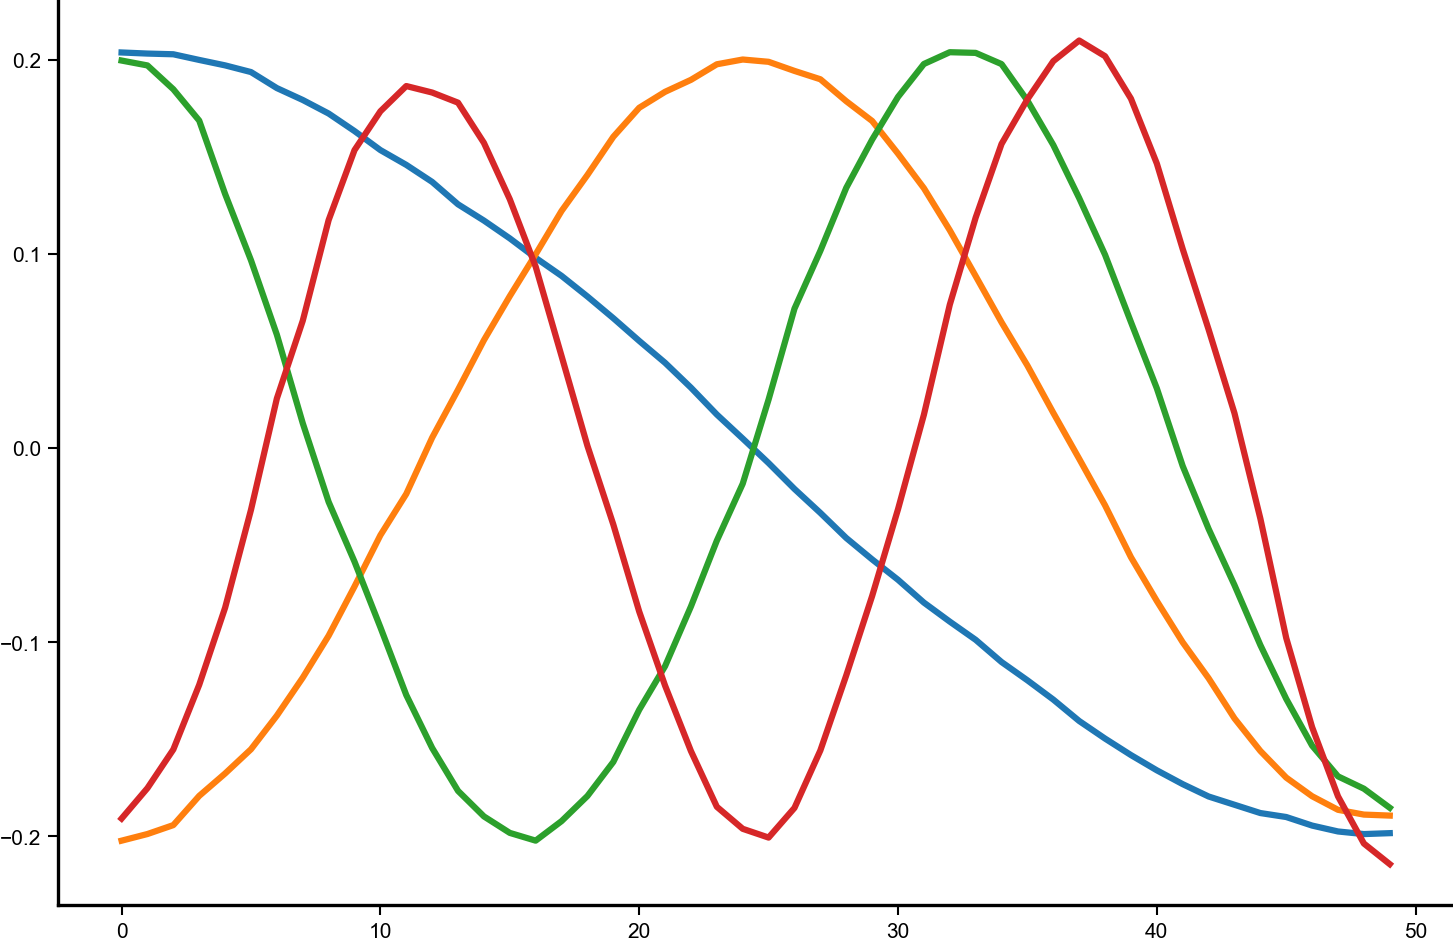

In [74]:
plt.plot(v_T[:,0])
plt.plot(v_T[:,1])
plt.plot(v_T[:,2])
plt.plot(v_T[:,3])

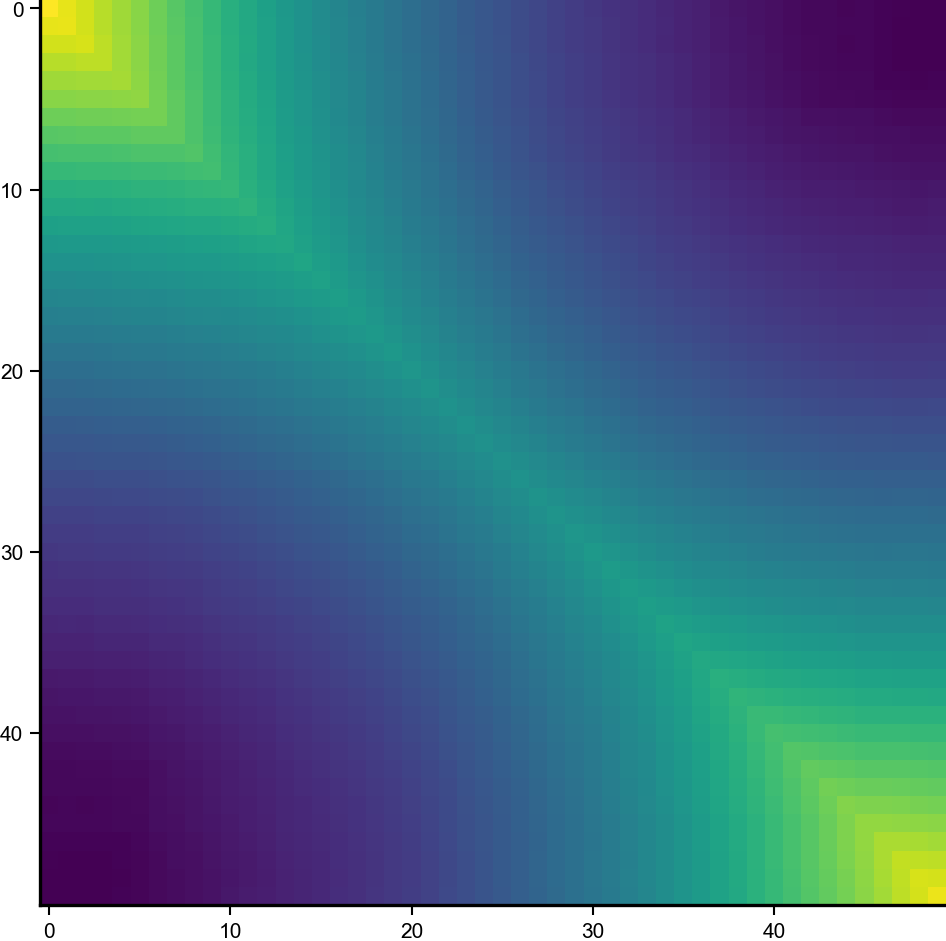

In [75]:
plt.imshow(X_hat.dot(X_hat.T))

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 40)

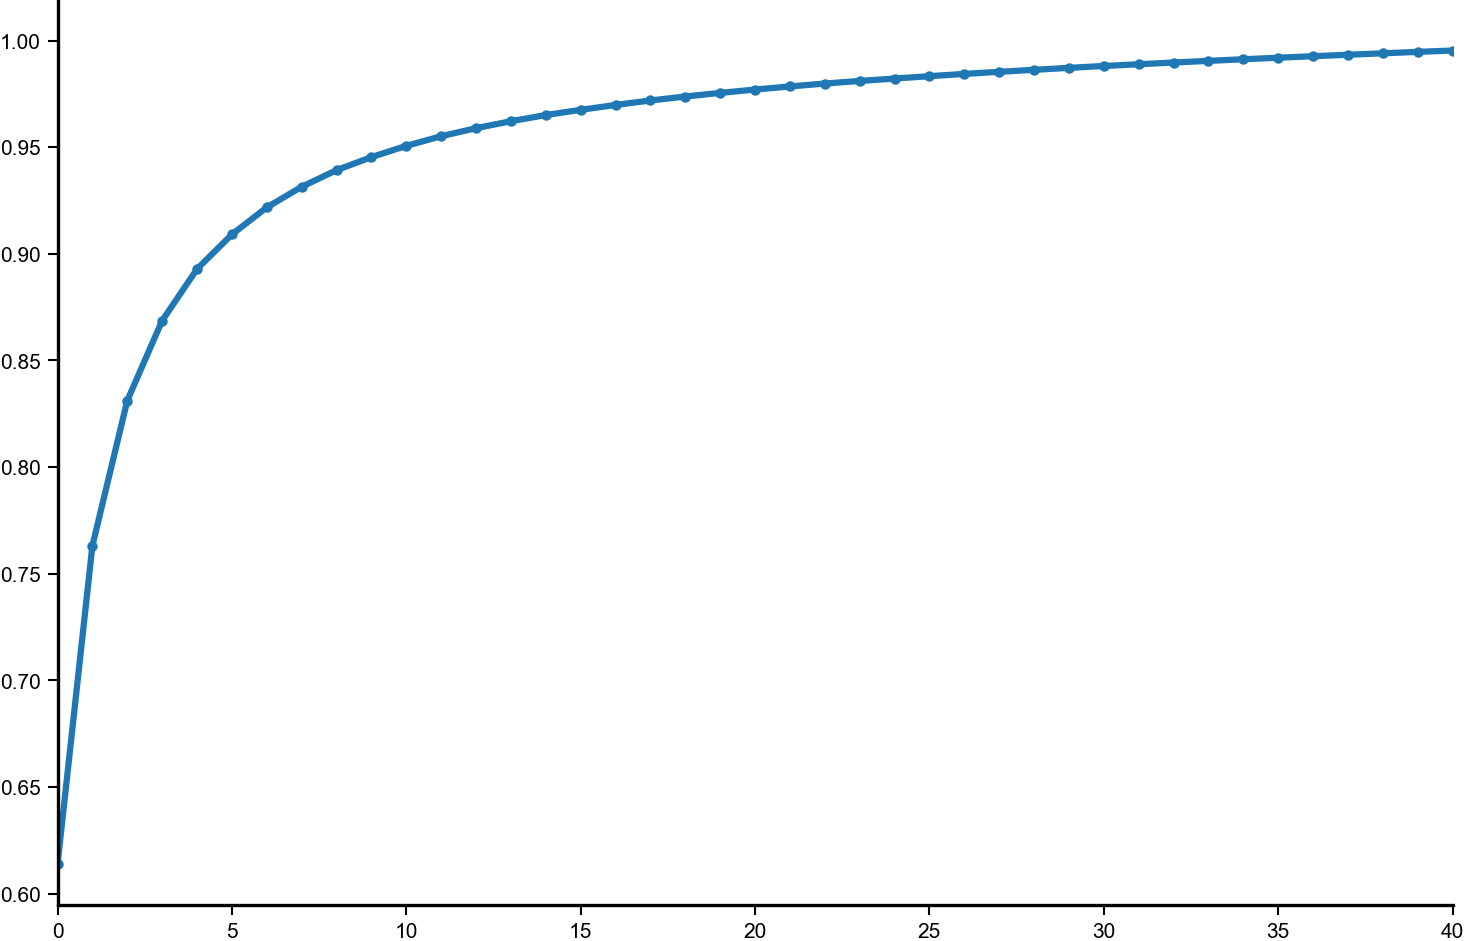

In [32]:
plt.plot(np.cumsum(w/sum(w)), '.-')
plt.xlim(0, 40)

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


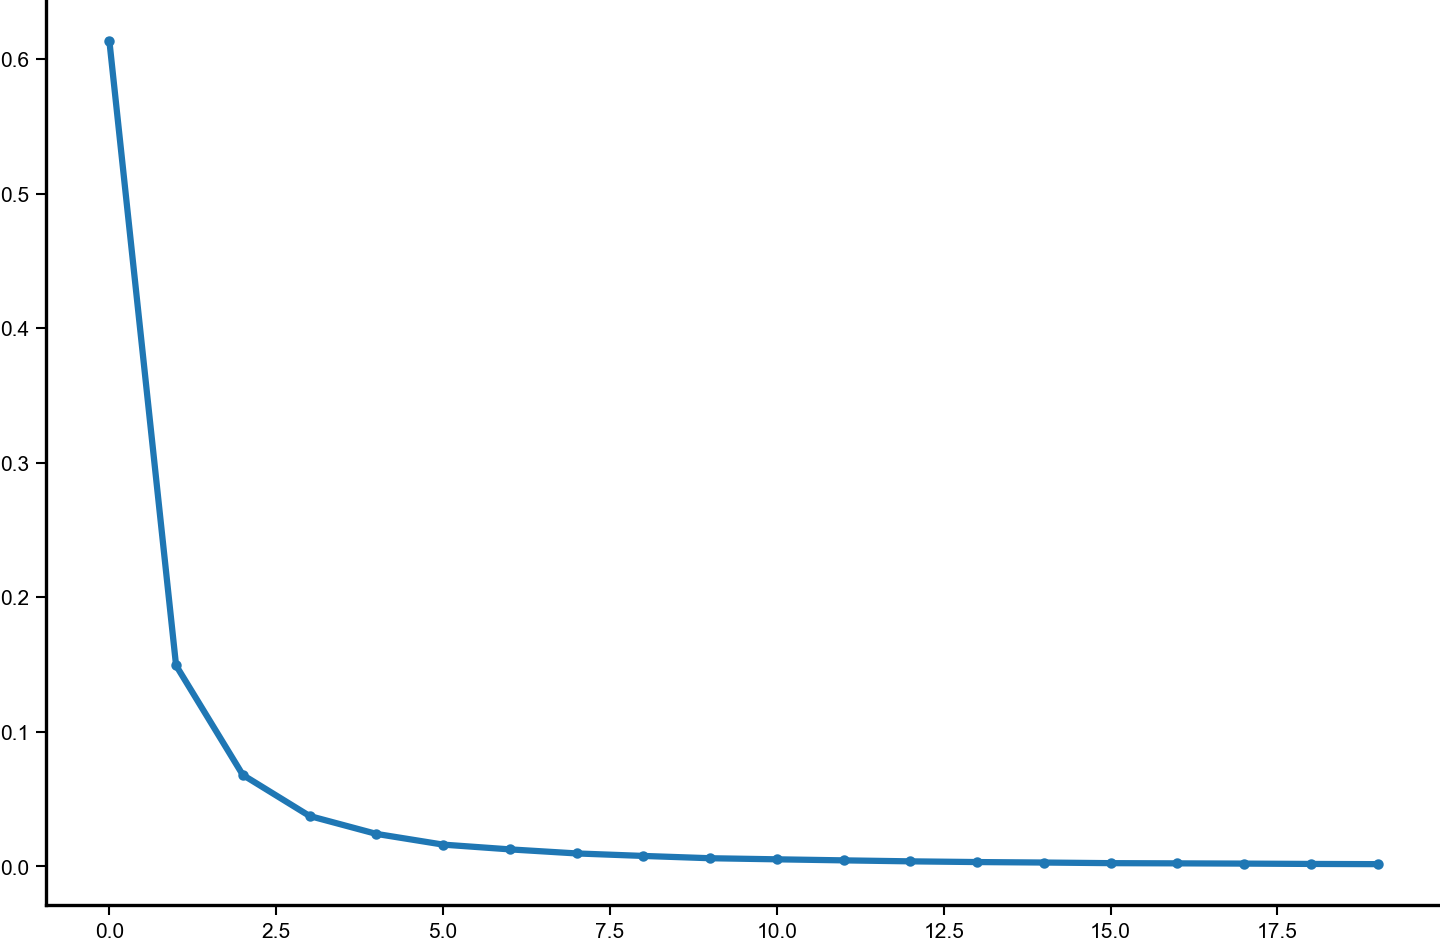

In [27]:
plt.plot(w[:20]/sum(w), '.-')

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: 

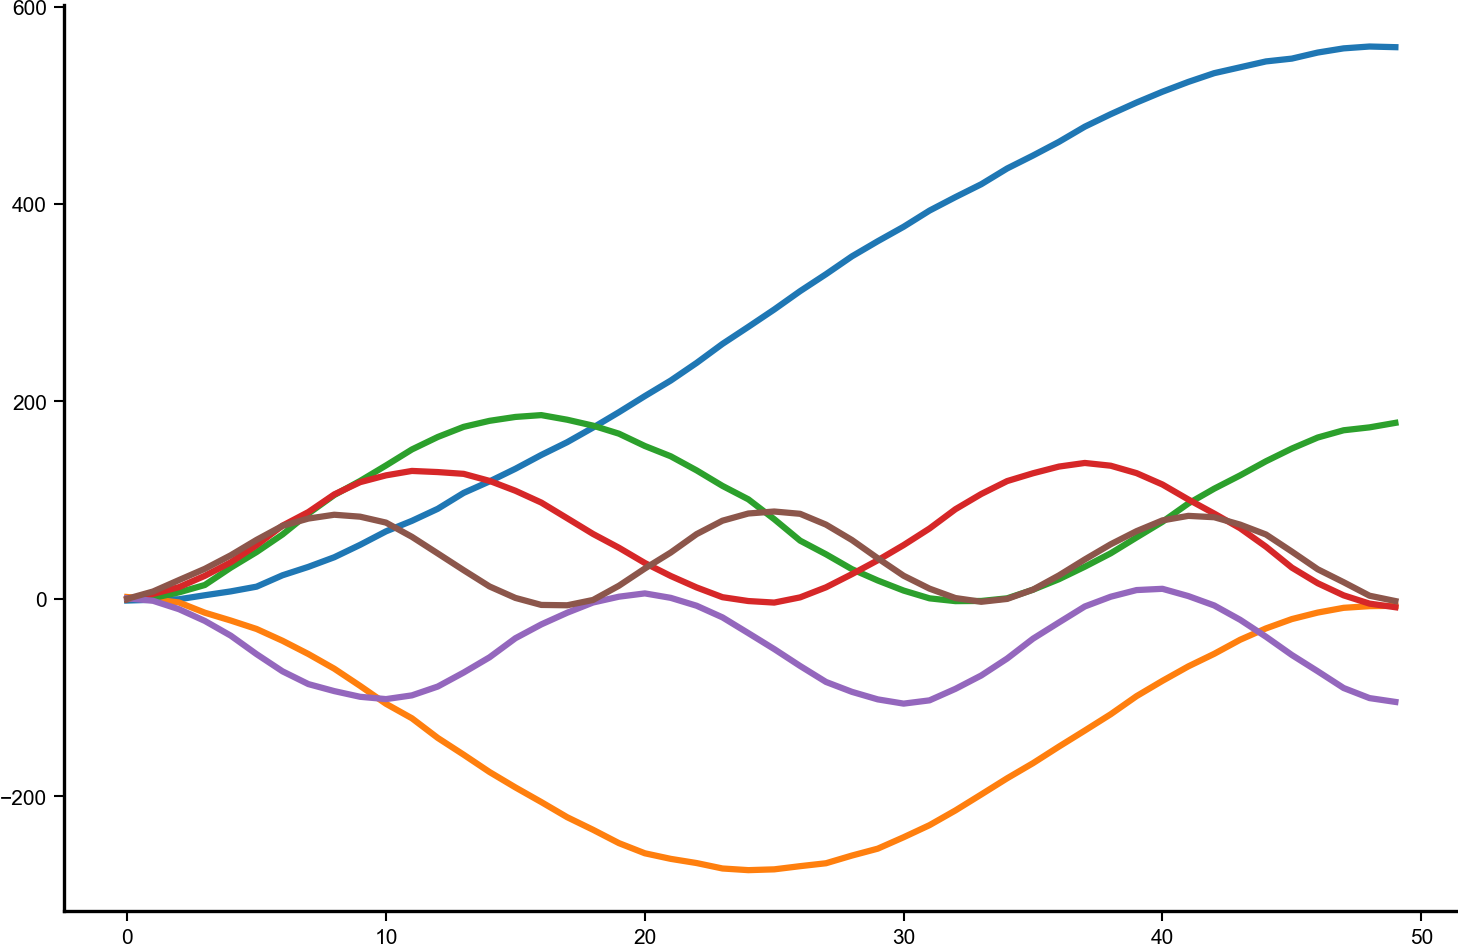

In [19]:
plt.plot(X_proj[:,0])
plt.plot(X_proj[:,1])
plt.plot(X_proj[:,2])
plt.plot(X_proj[:,3])
plt.plot(X_proj[:,4])
plt.plot(X_proj[:,5])

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


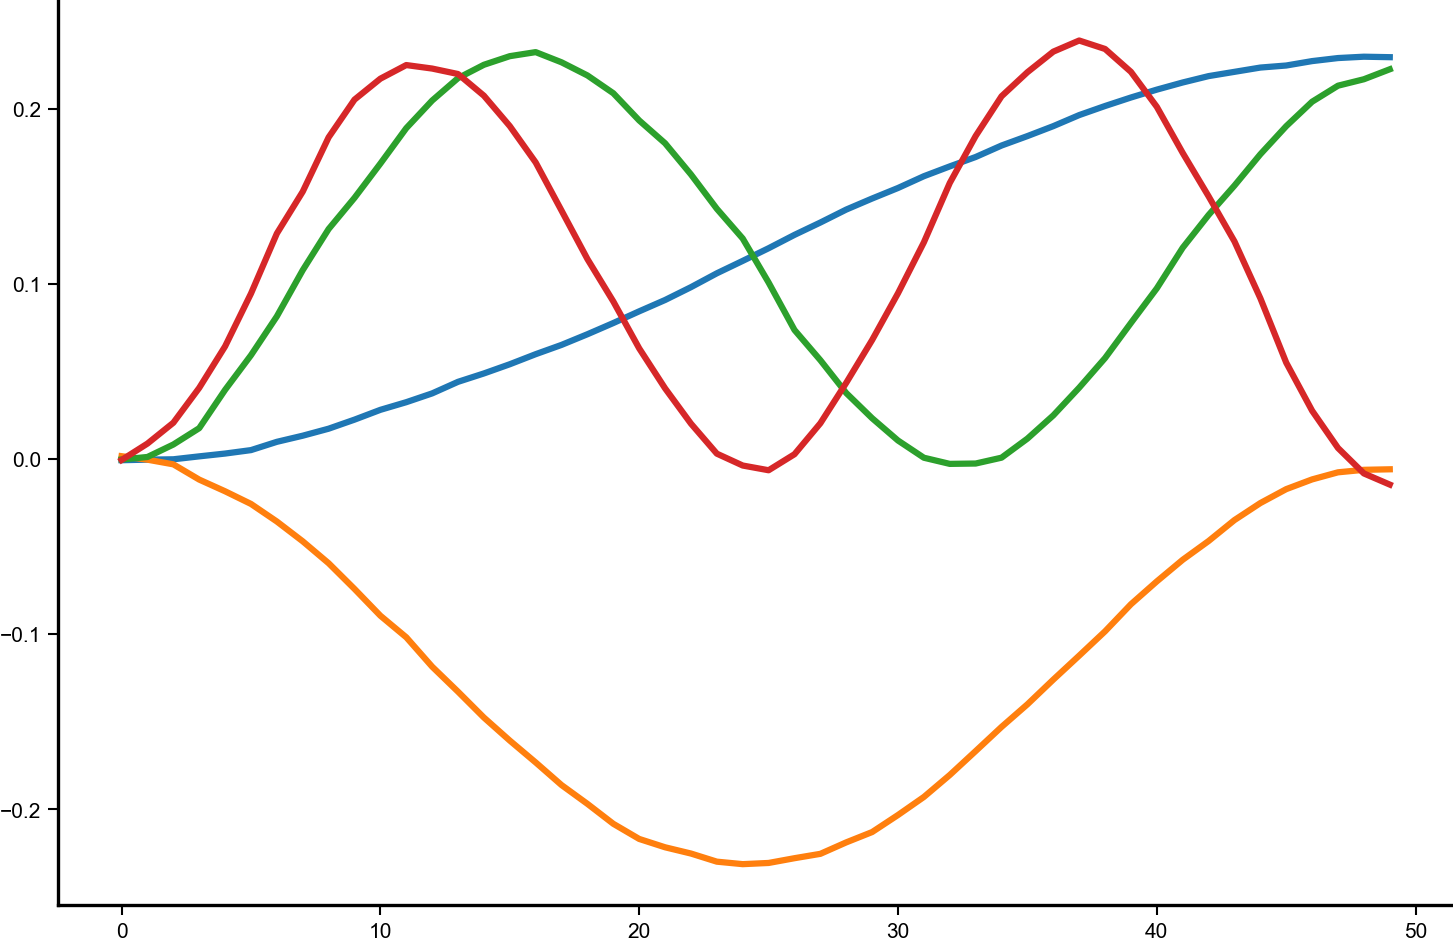

In [20]:
plt.plot(X_proj[:,0] / np.linalg.norm(X_proj[:,0]))
plt.plot(X_proj[:,1] / np.linalg.norm(X_proj[:,1]))
plt.plot(X_proj[:,2] / np.linalg.norm(X_proj[:,2]))
plt.plot(X_proj[:,3] / np.linalg.norm(X_proj[:,3]))

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=10)

In [36]:
pca.fit(X_hat.T)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

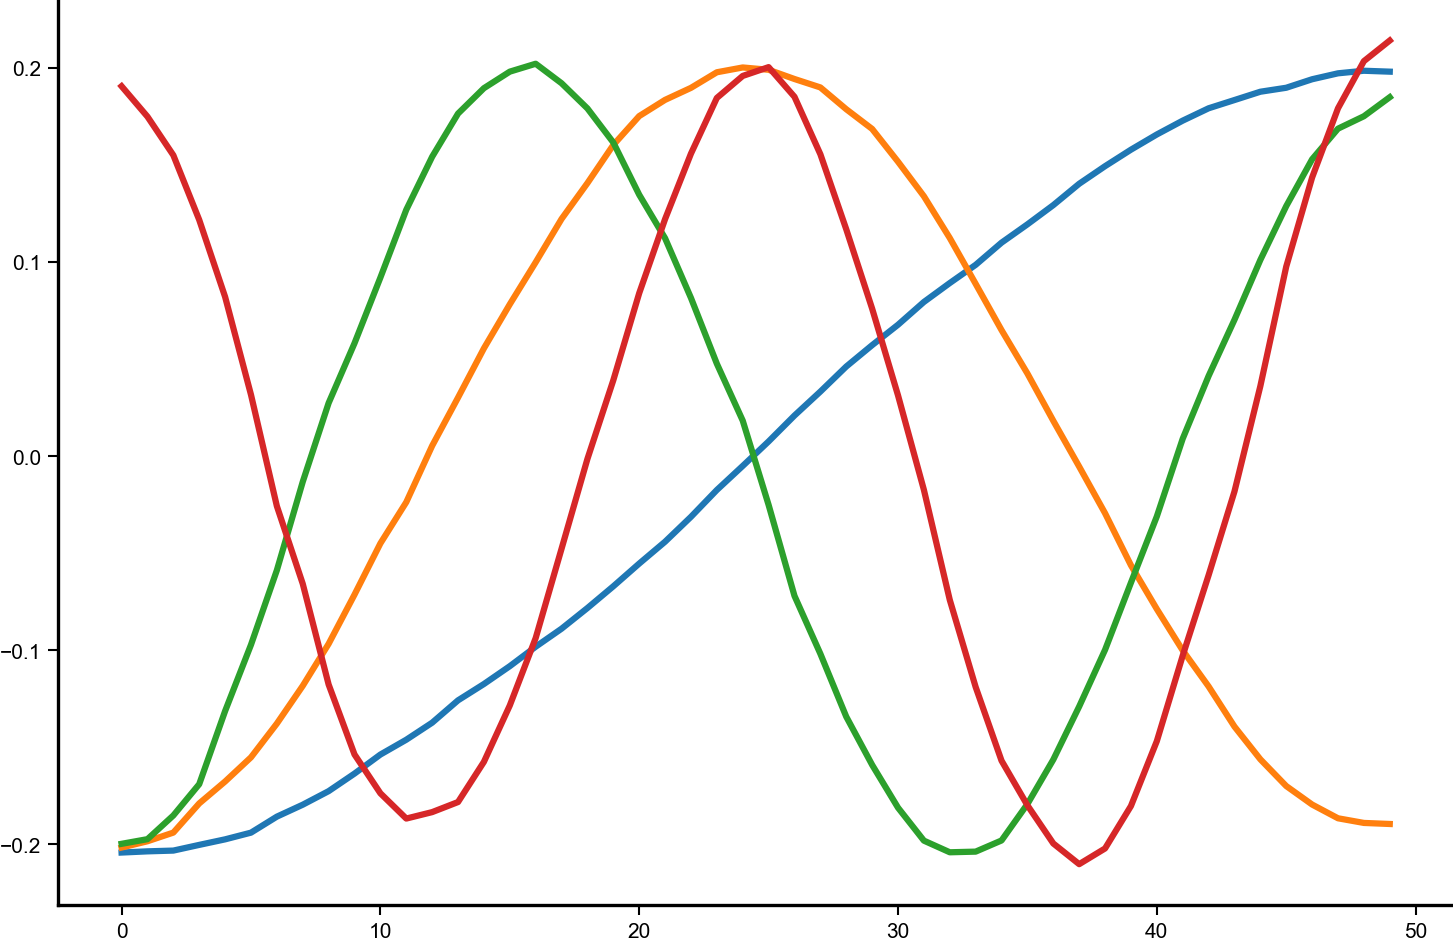

In [37]:
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])
plt.plot(pca.components_[2])
plt.plot(pca.components_[3])

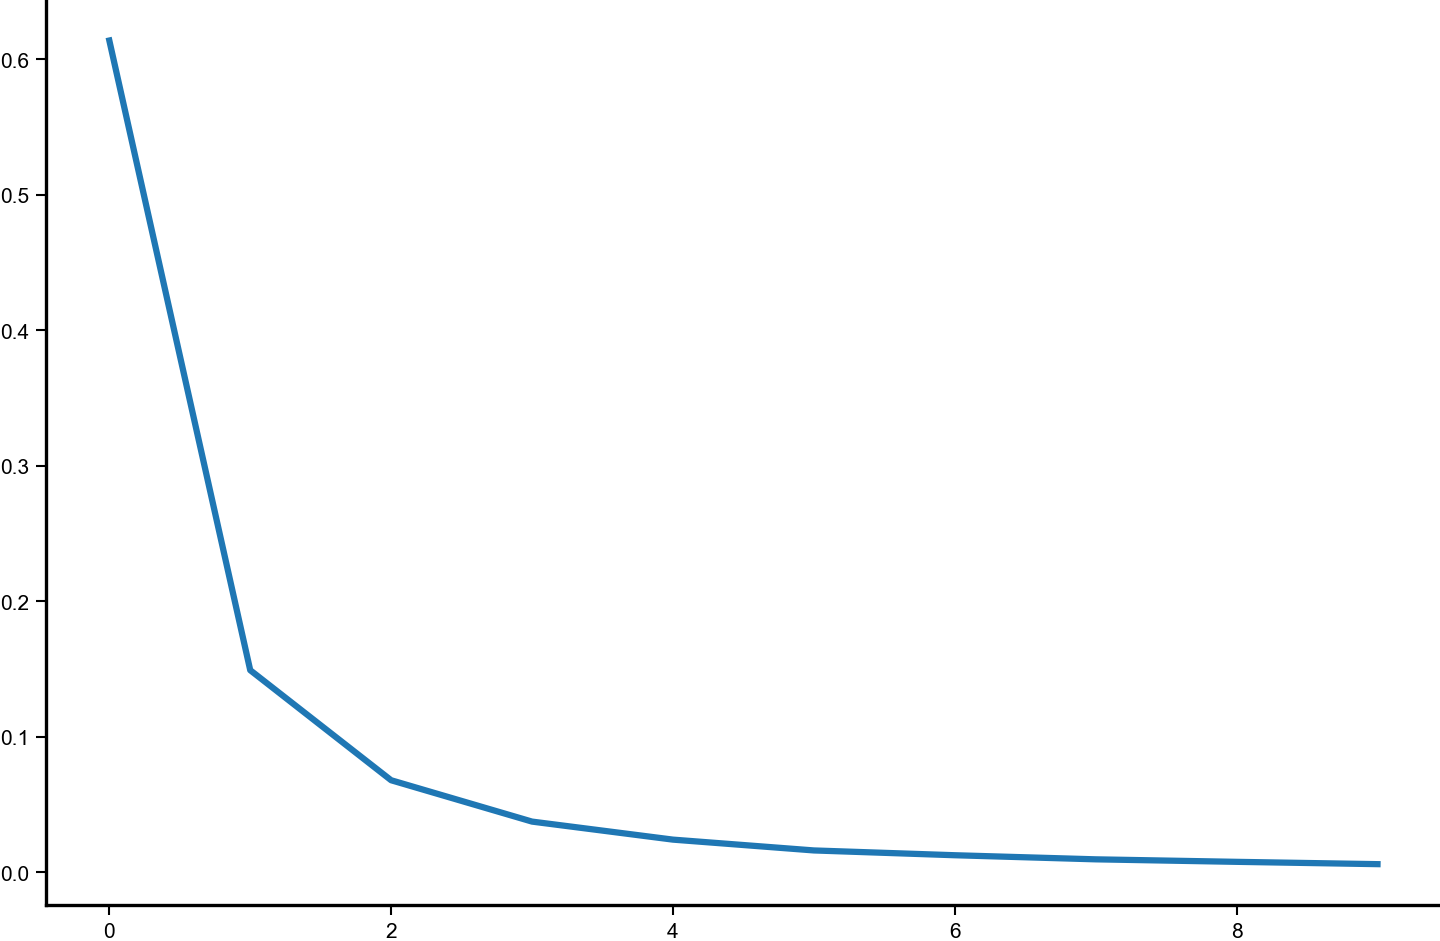

In [39]:
plt.plot(pca.explained_variance_ratio_[:20])

## Roots of unity

In [175]:
def omega(N, n):
    return np.exp(n * 2*np.pi*(0+1j) / N)

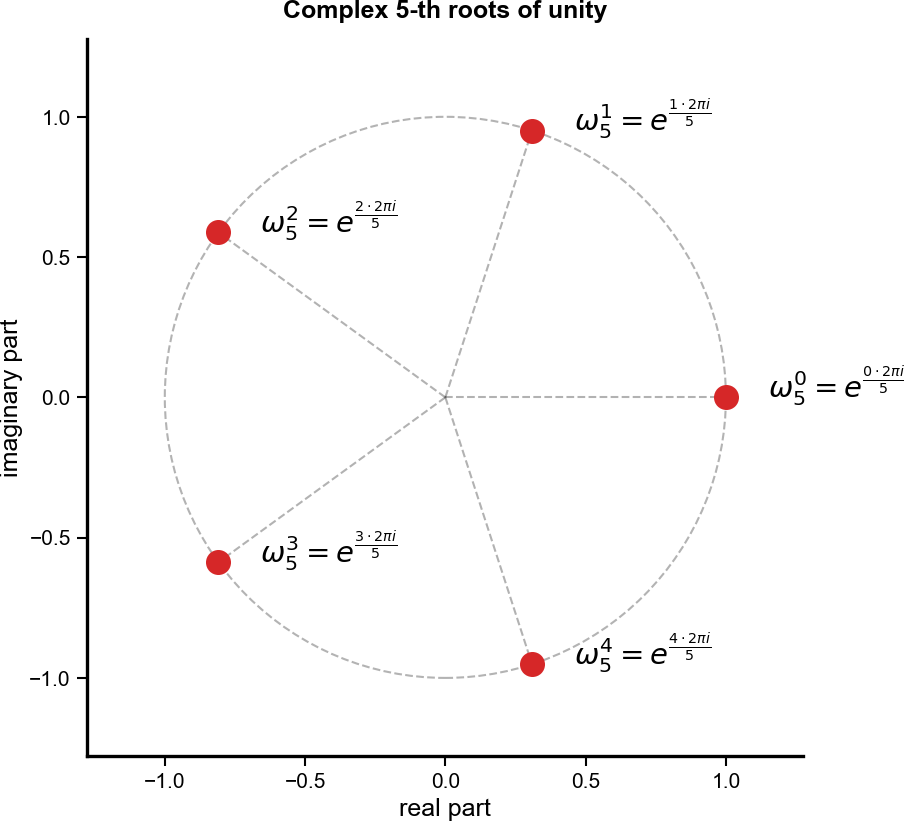

In [176]:
N = 5
roots = np.array([ omega(N, k) for k in range(N)])

plt.figure(figsize=cm2inch(8,7.5))
circle = plt.Circle((0,0), 1, ec='.7', fc='w', ls='--', lw=.5)
plt.gca().add_artist(circle)

for k, r in enumerate(roots):
    x, y = np.real(r), np.imag(r)
    plt.plot([0, x], [0, y], 'k--', lw=.5, alpha=.3)
    plt.plot(x, y, 'o', c='C3', ms=5)
    plt.annotate(f'$\omega_{N}^{k} = e^\\frac{{{k} \cdot 2\pi i}}{{{N}}}$', 
                 xy=(x,y), xytext=(10,0), textcoords='offset points')

    
plt.axis('equal');
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.ylabel('imaginary part')
plt.xlabel('real part')
plt.title(f'Complex {N}-th roots of unity')
plt.tight_layout()
plt.savefig('../figures/fig-roots-of-unity.pdf')

In [210]:
N = 12
omg = np.array([omega(N, n) ** k for n in range(N)])

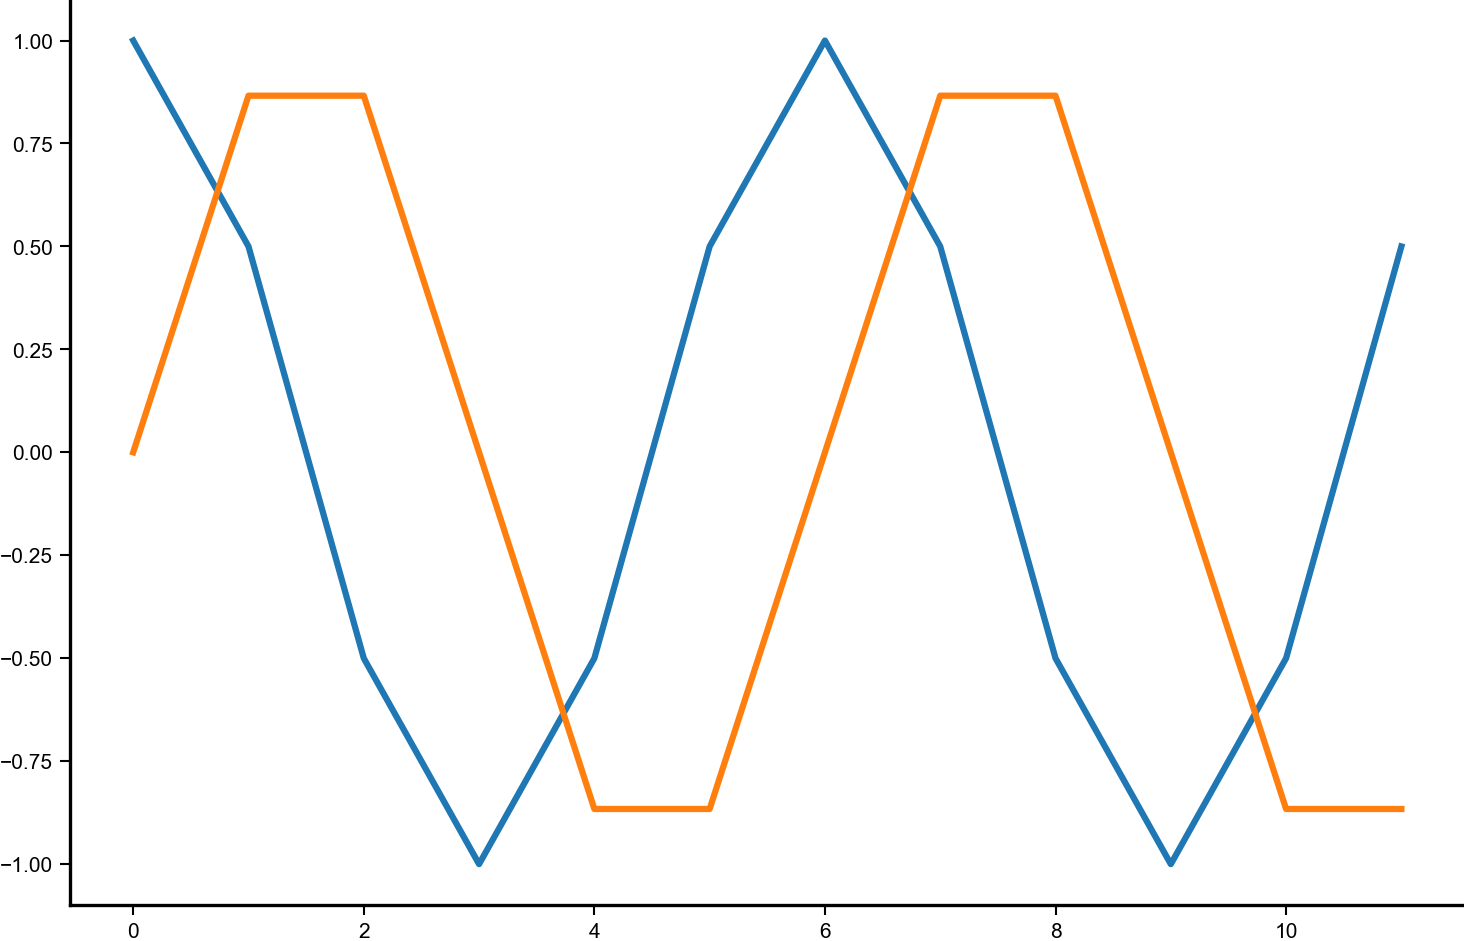

In [211]:
plt.plot(np.real(omg), label=f'$k={k}$')
plt.plot(np.imag(omg), label=f'$k={k}$')

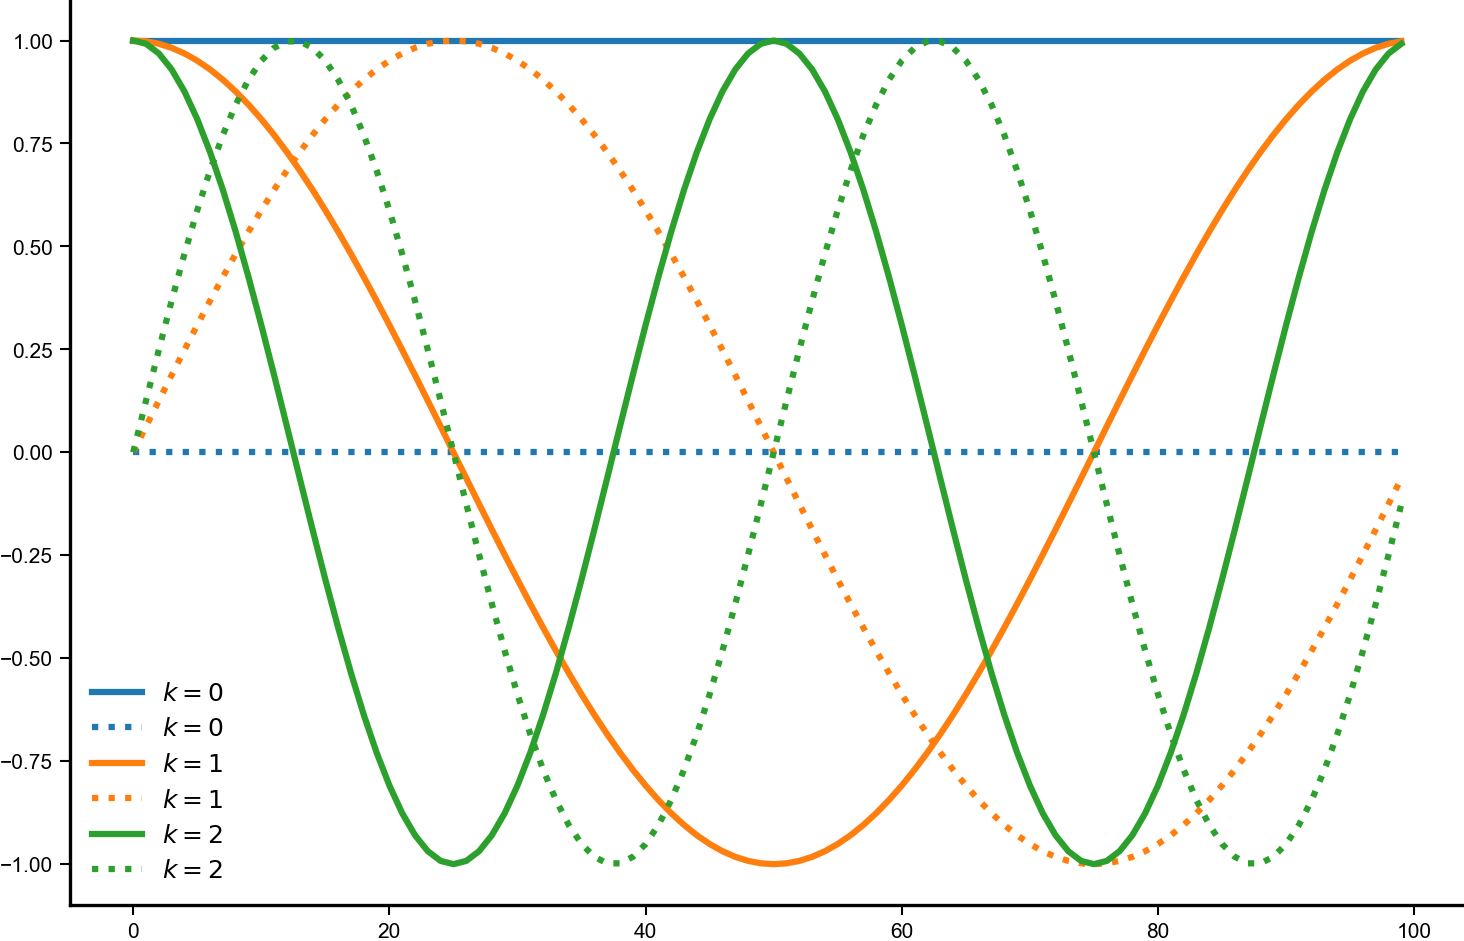

In [228]:
N = 100
for k in range(3):
#     k = np.mod(k, N)
    omg = np.array([omega(N, n) ** k for n in range(N)])
    l, = plt.plot(np.real(omg), label=f'$k={k}$')
    plt.plot(np.imag(omg), label=f'$k={k}$', color=l.get_color(), ls=':')

# k = 1
# omg = np.array([omega(N, n) ** k for n in range(N)])
# l, = plt.plot(np.imag(omg), label=f'$k={k}$')
plt.legend()

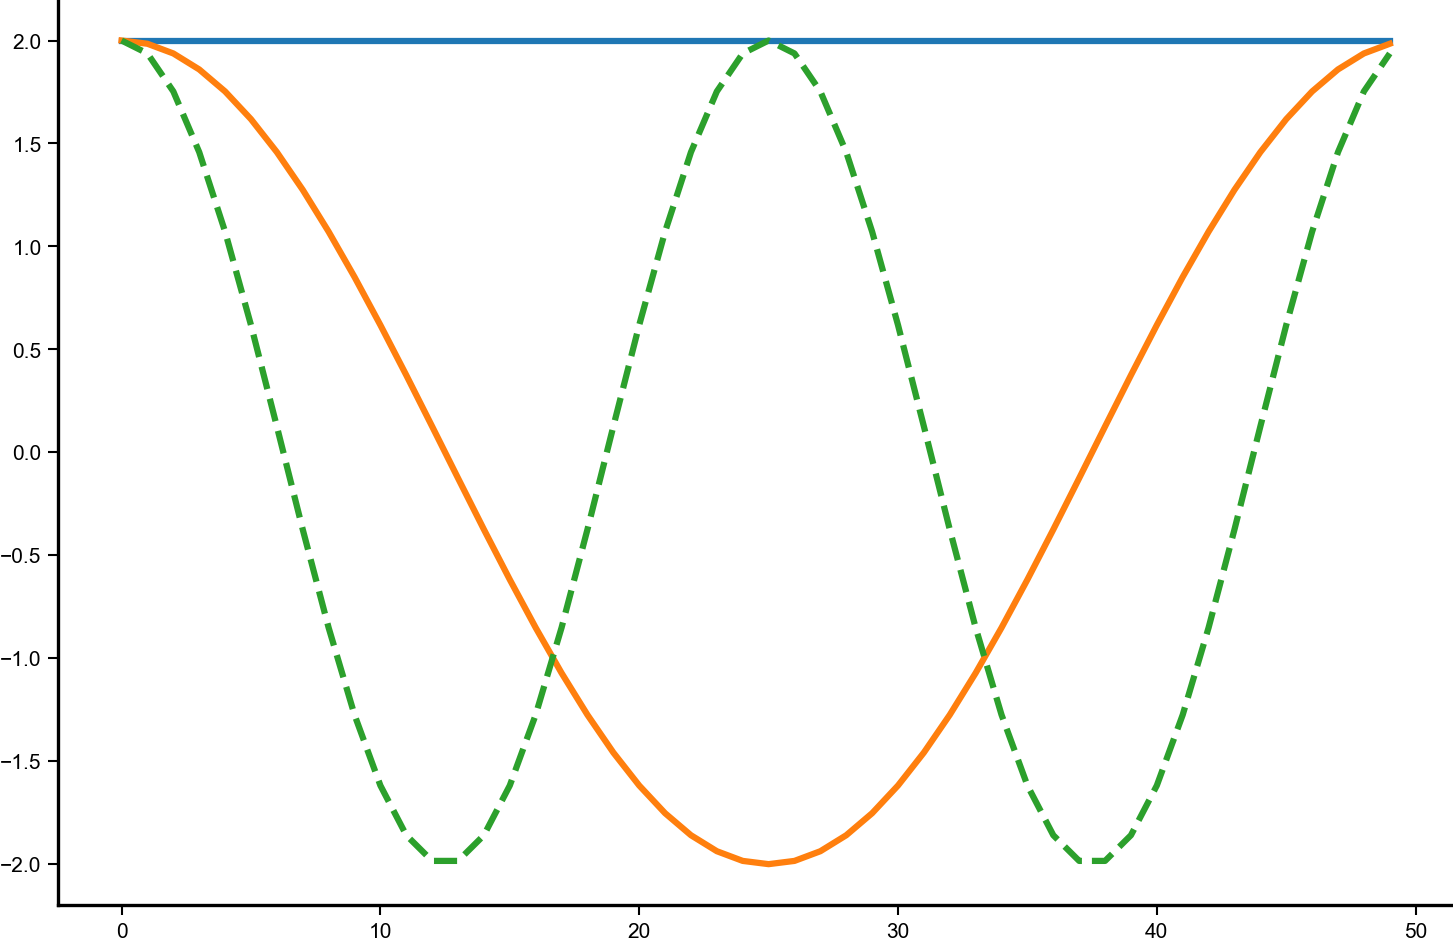

In [251]:
N = 50
for k in range(2):
    v = np.array([omega(N, n) ** k for n in range(N)])
    v_inv = np.array([omega(N, -n) ** k for n in range(N)])
    plt.plot(np.real(v+v_inv))
    
xs = np.arange(50)
ys = 2 * np.cos(xs * 2*np.pi/50)
ys = 2 * np.cos(xs * 3*np.pi/50)
ys = 2 * np.cos(xs * 4*np.pi/50)
plt.plot(xs, ys, '--')

In [252]:
def eig_vect(N, n):
    xs = np.arange(N)
    return np.cos(xs * np.pi * n / N)

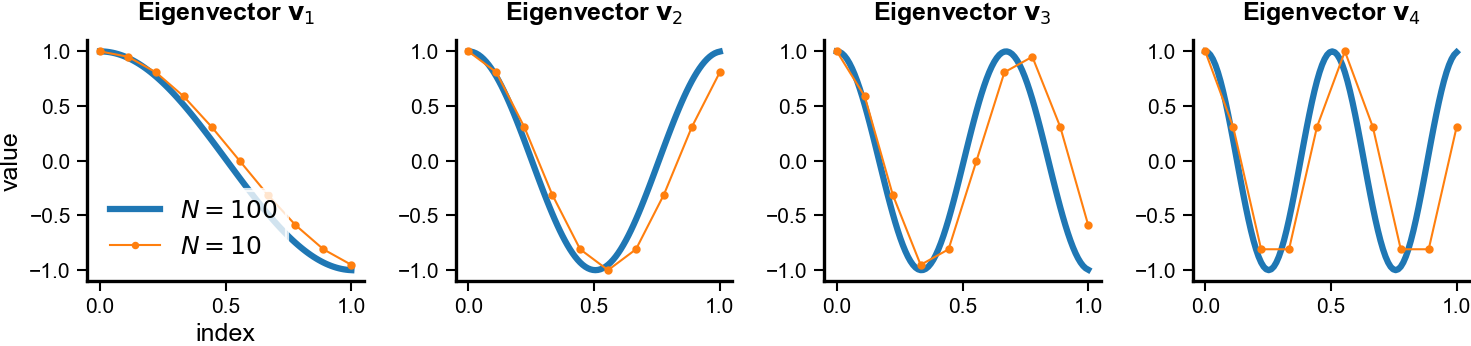

In [294]:
plt.figure(figsize=cm2inch(13, 3.5))
for n in range(1, 5):
    plt.subplot(int(f'14{n}'))
    plt.plot(np.linspace(0, 1, 100), eig_vect(100, n), '-', label='$N=100$')
    plt.plot(np.linspace(0, 1, 10), eig_vect(10, n), '.-', lw=.5, ms=2, label='$N=10$')
    if n == 1: 
        plt.legend()
        plt.ylabel('value')
        plt.xlabel('index')
    plt.title(f'Eigenvector $\mathbf{{v}}_{n}$')
    
    
plt.tight_layout()
plt.savefig('../figures/fig-eigen-vectors-circulant-matrix.pdf')

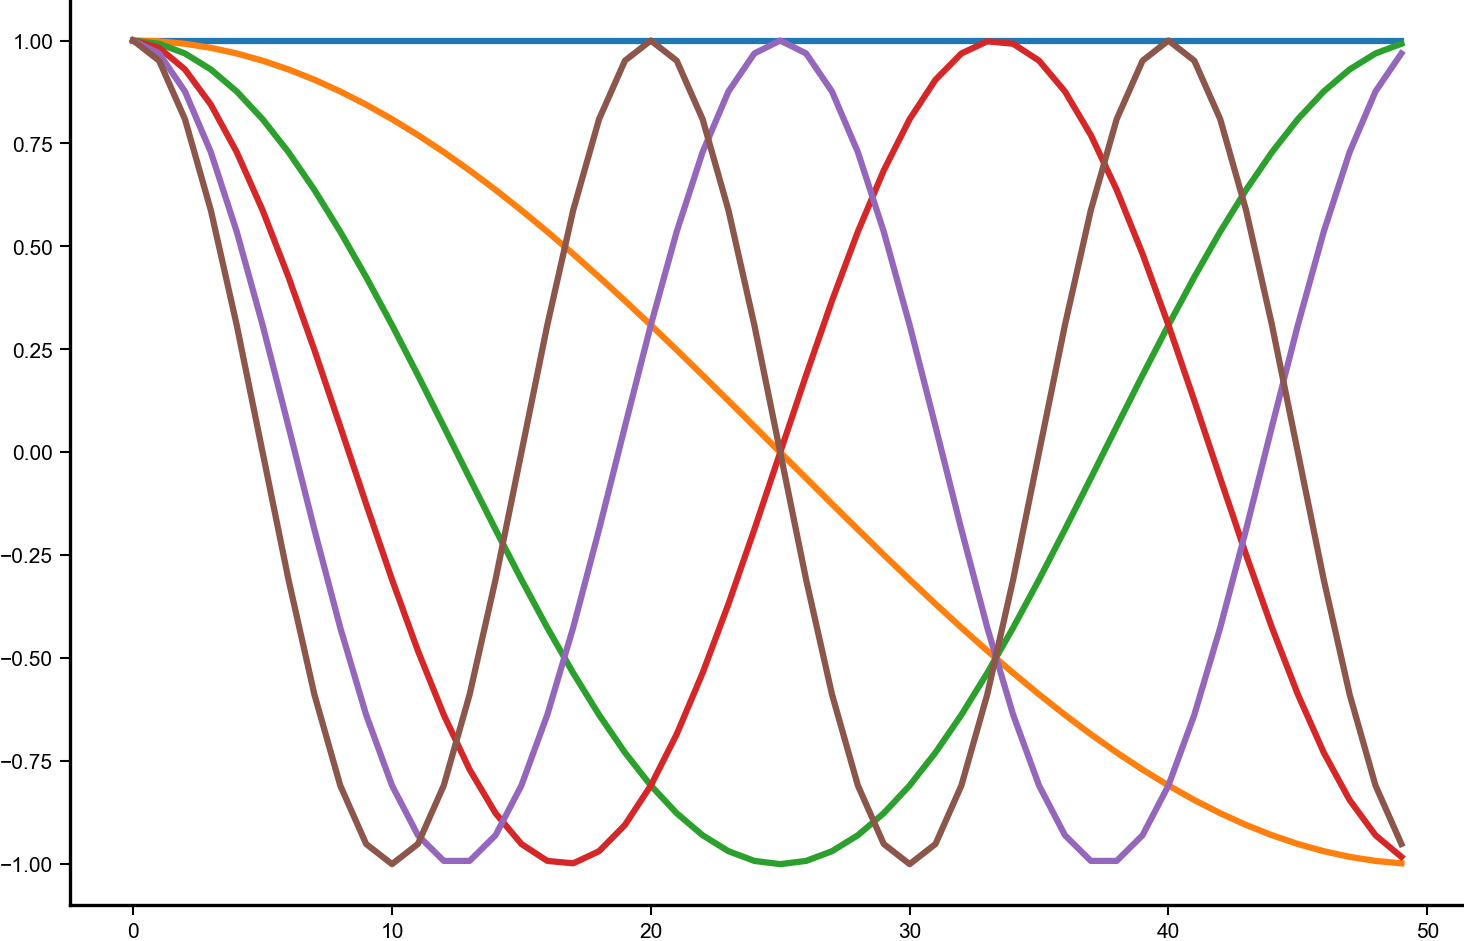

In [256]:
# xs = np.arange(50)
N = 50
plt.plot(eig_vect(N, 0))
plt.plot(eig_vect(N, 1))
plt.plot(eig_vect(N, 2))
plt.plot(eig_vect(N, 3))
plt.plot(eig_vect(N, 4))
plt.plot(eig_vect(N, 5))

In [19]:
plt.np(np.real(roots), np.imag(roots))

TypeError: 'module' object is not callable

In [ ]:
def omega(n, N):
    